
 Sample script using EEGNet to classify Event-Related Potential (ERP) EEG data
 from a four-class classification task, using the sample dataset provided in
 the MNE [1, 2] package:
     https://martinos.org/mne/stable/manual/sample_dataset.html#ch-sample-data
   
 The four classes used from this dataset are:
     LA: Left-ear auditory stimulation
     RA: Right-ear auditory stimulation
     LV: Left visual field stimulation
     RV: Right visual field stimulation

 The code to process, filter and epoch the data are originally from Alexandre
 Barachant's PyRiemann [3] package, released under the BSD 3-clause. A copy of 
 the BSD 3-clause license has been provided together with this software to 
 comply with software licensing requirements. 
 
 When you first run this script, MNE will download the dataset and prompt you
 to confirm the download location (defaults to ~/mne_data). Follow the prompts
 to continue. The dataset size is approx. 1.5GB download. 
 
 For comparative purposes you can also compare EEGNet performance to using 
 Riemannian geometric approaches with xDAWN spatial filtering [4-8] using 
 PyRiemann (code provided below).

 [1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck,
     L. Parkkonen, M. Hämäläinen, MNE software for processing MEG and EEG data, 
     NeuroImage, Volume 86, 1 February 2014, Pages 446-460, ISSN 1053-8119.

 [2] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, 
     R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data 
     analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013.

 [3] https://github.com/alexandrebarachant/pyRiemann. 

 [4] A. Barachant, M. Congedo ,"A Plug&Play P300 BCI Using Information Geometry"
     arXiv:1409.0107. link

 [5] M. Congedo, A. Barachant, A. Andreev ,"A New generation of Brain-Computer 
     Interface Based on Riemannian Geometry", arXiv: 1310.8115.

 [6] A. Barachant and S. Bonnet, "Channel selection procedure using riemannian 
     distance for BCI applications," in 2011 5th International IEEE/EMBS 
     Conference on Neural Engineering (NER), 2011, 348-351.

 [7] A. Barachant, S. Bonnet, M. Congedo and C. Jutten, “Multiclass 
     Brain-Computer Interface Classification by Riemannian Geometry,” in IEEE 
     Transactions on Biomedical Engineering, vol. 59, no. 4, p. 920-928, 2012.

 [8] A. Barachant, S. Bonnet, M. Congedo and C. Jutten, “Classification of 
     covariance matrices using a Riemannian-based kernel for BCI applications“, 
     in NeuroComputing, vol. 112, p. 172-178, 2013.


 Portions of this project are works of the United States Government and are not
 subject to domestic copyright protection under 17 USC Sec. 105.  Those 
 portions are released world-wide under the terms of the Creative Commons Zero 
 1.0 (CC0) license.  
 
 Other portions of this project are subject to domestic copyright protection 
 under 17 USC Sec. 105.  Those portions are licensed under the Apache 2.0 
 license.  The complete text of the license governing this material is in 
 the file labeled LICENSE.TXT that is a part of this project's official 
 distribution. 


In [3]:
import numpy as np
import pickle

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

In [4]:
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

In [7]:
def load_dataset(user_split = True):
    X_train = None
    y_train_medid = None
    y_train_subjid = None
    X_val = None
    y_val_medid = None
    y_val_subjid = None
    X_test = None
    y_test_medid = None
    y_test_subjid = None

    # user_split: Determines the creation of train/val/test set. In user_split, test/val users are never seen during the train. time_split randomly splits each user's chunks into train/val/test.
    if user_split:
        data_file_path = '../../data/Meditation/user_based_splits.pkl'
    else:
        data_file_path = '../../data/Meditation/time_based_splits.pkl'

    with open(data_file_path, 'rb') as f:
        all_data_splits = pickle.load(f)

        X_train = all_data_splits['train']['x']
        y_train_medid = all_data_splits['train']['y_med']
        y_train_subjid = all_data_splits['train']['y_subj']

        X_val = all_data_splits['val']['x']
        y_val_medid = all_data_splits['val']['y_med']
        y_val_subjid = all_data_splits['val']['y_subj']

        X_test = all_data_splits['test']['x']
        y_test_medid = all_data_splits['test']['y_med']
        y_test_subjid = all_data_splits['test']['y_subj']

    return X_train, y_train_medid, y_train_subjid, X_val, y_val_medid, y_val_subjid, X_test, y_test_medid, y_test_subjid

In [21]:
np.unique(y_train_subjid)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [22]:
def train_model(user_split, med_tech_clf, X_train, y_train_medid, y_train_subjid, X_val, y_val_medid, y_val_subjid, X_test, y_test_medid, y_test_subjid):
    
    kernels, chans, samples = 1, 64, 2560
    
    split_strat = 'user' if user_split else 'time'
    
    # Data split is 60/20/20 as train/validate/test
    if med_tech_clf:
        Y_train      = y_train_medid
        Y_validate   = y_val_medid
        Y_test       = y_test_medid
        ckpt_file_suffix = '{}_med_clf'.format(split_strat)
    else:
        Y_train      = y_train_subjid
        Y_validate   = y_val_subjid
        Y_test       = y_test_subjid
        ckpt_file_suffix = '{}_subj_clf'.format(split_strat)
    nb_classes = np.unique(Y_train).shape[0]
    
    
    ############################# EEGNet portion ##################################
    # convert labels to one-hot encodings.
    Y_train      = np_utils.to_categorical(Y_train)
    Y_validate   = np_utils.to_categorical(Y_validate)
    Y_test       = np_utils.to_categorical(Y_test)

    # convert data to NHWC (trials, channels, samples, kernels) format. Data 
    # contains 60 channels and 151 time-points. Set the number of kernels to 1.
    X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
    X_val        = X_val.reshape(X_val.shape[0], chans, samples, kernels)
    X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
    
    # configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
    # model configurations may do better, but this is a good starting point)
    model = EEGNet(nb_classes = nb_classes, Chans = chans, Samples = samples, 
                   dropoutRate = 0.5, kernLength = 128, F1 = 8, D = 2, F2 = 16, 
                   dropoutType = 'Dropout')

    # compile the model and set the optimizers
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics = ['accuracy'])

    # count number of parameters in the model
    numParams    = model.count_params()    

    # set a valid path for your system to record model checkpoints
    checkpointer = ModelCheckpoint(filepath='./ckpt/checkpoint_{}.h5'.format(ckpt_file_suffix), 
                                   verbose=1, save_best_only=True)
    
    ###############################################################################
    # if the classification task was imbalanced (significantly more trials in one
    # class versus the others) you can assign a weight to each class during 
    # optimization to balance it out. This data is approximately balanced so we 
    # don't need to do this, but is shown here for illustration/completeness. 
    ###############################################################################

    # the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
    # the weights all to be 1
    class_weights = {cl: 1 for cl in range(nb_classes)}

    ################################################################################
    # fit the model. Due to very small sample sizes this can get
    # pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
    # Riemannian geometry classification (below)
    ################################################################################
    escallback = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3)
    fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 20, 
                            verbose = 2, validation_data=(X_val, Y_validate),
                            callbacks=[checkpointer, escallback], class_weight = class_weights)

    # load optimal weights
    model.load_weights('./ckpt/checkpoint_{}.h5'.format(ckpt_file_suffix))
    
    probs       = model.predict(X_test)
    preds       = probs.argmax(axis = -1)  
    acc         = np.mean(preds == Y_test.argmax(axis=-1))
    print("EEGNet Classification accuracy: %f " % (acc))
    
    if med_tech_clf:
        names        = ["HT", "SNY", "VIP", "CTR"]
    else:
        names         = ['subj_{}'.format(x) for x in range(nb_classes)]
    
    try:
        plt.clf()
    except Exception:
        pass
    
    plt.figure()
    plot_confusion_matrix(preds, Y_test.argmax(axis = -1), names, title = 'EEGNet-8,2')
    plt.savefig('./figures/cm_userpred_eegnet_{}.png'.format(ckpt_file_suffix))
    plt.show()
    
    return preds, [], Y_test
    
#     ############################# PyRiemann Portion ##############################
#     # code is taken from PyRiemann's ERP sample script, which is decoding in 
#     # the tangent space with a logistic regression
#     n_components = 2  # pick some components

#     # set up sklearn pipeline
#     clf = make_pipeline(XdawnCovariances(n_components),
#                         TangentSpace(metric='riemann'),
#                         LogisticRegression())
#     preds_rg     = np.zeros(len(Y_test))

#     # reshape back to (trials, channels, samples)
#     X_train      = X_train.reshape(X_train.shape[0], chans, samples)
#     X_test       = X_test.reshape(X_test.shape[0], chans, samples)

#     # train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
#     # labels need to be back in single-column format
#     clf.fit(X_train, Y_train.argmax(axis = -1))
#     preds_rg     = clf.predict(X_test)

#     # Printing the results
#     acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
#     print("PyRiemann Classification accuracy: %f " % (acc2))

#     # plot the confusion matrices for both classifiers
#     if med_tech_clf:
#         names        = ["HT", "SNY", "VIP", "CTR"]
#     else:
#         name         = ['subj_{}'.format(x) for x in range(nb_classes)]
    
    

#     plt.figure()
#     plot_confusion_matrix(preds_rg, Y_test.argmax(axis = -1), names, title = 'xDAWN + RG')
#     plt.savefig('./figures/cm_userpred_xdawn_{}.png'.format(ckpt_file_suffix))
#     plt.show()
    
#     return preds, preds_rg, Y_test

### User Id prediction

##### Time based splitting

Can only do time-based splitting here as user-based splitting will involve predicting the userids that are not even seen during the train stage.

X_train shape: (1954, 64, 2560, 1)
1954 train samples
688 test samples
Epoch 1/20

Epoch 1: val_loss improved from inf to 2.87948, saving model to ./ckpt/checkpoint_time_subj_clf.h5
123/123 - 178s - loss: 3.2624 - accuracy: 0.2421 - val_loss: 2.8795 - val_accuracy: 0.6203 - 178s/epoch - 1s/step
Epoch 2/20

Epoch 2: val_loss improved from 2.87948 to 1.91118, saving model to ./ckpt/checkpoint_time_subj_clf.h5
123/123 - 176s - loss: 1.6920 - accuracy: 0.7620 - val_loss: 1.9112 - val_accuracy: 0.8472 - 176s/epoch - 1s/step
Epoch 3/20

Epoch 3: val_loss improved from 1.91118 to 1.20228, saving model to ./ckpt/checkpoint_time_subj_clf.h5
123/123 - 176s - loss: 1.0980 - accuracy: 0.9140 - val_loss: 1.2023 - val_accuracy: 0.9213 - 176s/epoch - 1s/step
Epoch 4/20

Epoch 4: val_loss improved from 1.20228 to 0.99781, saving model to ./ckpt/checkpoint_time_subj_clf.h5
123/123 - 177s - loss: 0.7808 - accuracy: 0.9688 - val_loss: 0.9978 - val_accuracy: 0.9592 - 177s/epoch - 1s/step
Epoch 5/20

Epoch

<Figure size 640x480 with 0 Axes>

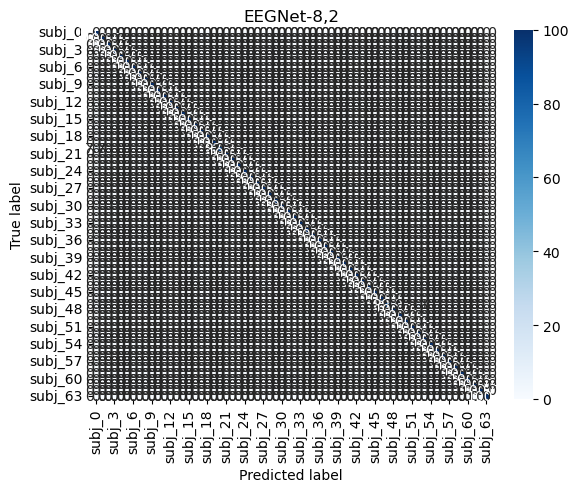

In [23]:
user_split   = False
med_tech_clf = False

X_train, y_train_medid, y_train_subjid, X_val, y_val_medid, y_val_subjid, X_test, y_test_medid, y_test_subjid = load_dataset(user_split=user_split)

preds_eegnet, preds_rg, actual_labels = train_model(user_split, med_tech_clf, X_train, y_train_medid, y_train_subjid, X_val, y_val_medid, y_val_subjid, X_test, y_test_medid, y_test_subjid)

In [24]:
print("Done!!!")

Done!!!
